In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

In [9]:
#General visualization settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)

In [10]:
#Path settings
root_path = Path(r"C:\Users\neurogears\OneDrive - NeuroGEARS Ltd\CricketPrelemdata\ArmBenchmarking")
session_id = "05_06_2022_16_02_29"
session_path = root_path / session_id


#### SWC-HARP and CF-HARP timing benchmarking

[0.98192024 0.98870039 0.9791398  0.97840023 0.98842001 0.97871971
 0.98880005 0.98867989 0.97863007 0.98921013 0.98883009 0.97833014
 0.97907972 0.97859001 0.97846985 0.98912001 0.97901011 0.98863983
 0.97898006 0.98863983 0.98875999 0.97874975]
Mean±std  :  983.45 [ms] ± 4.92


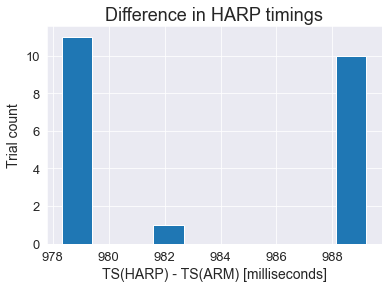

In [30]:
## Compare SWC-HARP and CF-HARP timestamping

#Load data from SWC-HARP
#Note: ARM gpio event is triggered on a falling edge
arm_falling_edge = pd.read_csv(session_path / "ArmFallingEdgeDetection.csv")
arm_falling_edge = arm_falling_edge["ToString()"].values

#Load data from CF-HARP
#Note: there is a bug wherein i am using the rising edge of a very short pulse.
#Should fix in the future!
harp_io = pd.read_csv(session_path / "BehaviorSynchPulse.csv")
harp_falling_edge = harp_io["Seconds"].values

#Calculate the timing difference
deltaTS = harp_falling_edge - arm_falling_edge

#Plot the distribution of the differences
plt.figure()
plt.hist(deltaTS*1000)
plt.xlabel("TS(HARP) - TS(ARM) [milliseconds]")
plt.ylabel("Trial count")
plt.title("Difference in HARP timings")
print(deltaTS)
print("Mean±std  :  {0:.2f} [ms] ± {1:.2f}".format(np.mean(deltaTS*1000), np.std(deltaTS*1000)))